# Finetuning model

## Testing Fine-tuning

In [1]:
from huggingface_hub import notebook_login

notebook_login()

## Transforming dataset :

In [266]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

csv = "/content/drive/MyDrive/UH - Final Year Project/data/df-iter-1.csv"
df = pd.read_csv(csv)
df

,sentence,vars,names,variable_position
0,The loading term becomes relevant at a time τ,['τ'],a time,['end']
1,we get easily for the rupture force f ∗,['f'],the rupture force,['end']
2,Green’s theorem can be used to show that the v...,['d3xG(x)'],the volume,['end']
3,at a ﬁxed point x,['x'],['point'],['end']
4,it will be quite small (|K| is large) around t...,['x'],the point,['end']
...,...,...,...,...
296,we are inspired by the recent advances in the ...,['(information)'],quantum,['end']
297,"then the correlation function C(A, B)","['C(A, B)']",the correlation function,['end']
298,Next is to utilize the perturbation expansion ...,['f'],the longitudinal distribution function,['end']
299,the resonator voltage V f,['V'],the resonator voltage,['end']


In [267]:
# drop unecessary "[]" inside names
df["names"] = df["names"].apply(lambda name: name.strip("[]'"))
df['vars'] = df['vars'].apply(lambda x: x.strip("[]'"))
df.drop(columns=["variable_position"],inplace=True)

In [268]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  301 non-null    object
 1   vars      301 non-null    object
 2   names     301 non-null    object
dtypes: object(3)
memory usage: 7.2+ KB


In [269]:
df

,sentence,vars,names
0,The loading term becomes relevant at a time τ,τ,a time
1,we get easily for the rupture force f ∗,f,the rupture force
2,Green’s theorem can be used to show that the v...,d3xG(x),the volume
3,at a ﬁxed point x,x,point
4,it will be quite small (|K| is large) around t...,x,the point
...,...,...,...
296,we are inspired by the recent advances in the ...,(information),quantum
297,"then the correlation function C(A, B)","C(A, B)",the correlation function
298,Next is to utilize the perturbation expansion ...,f,the longitudinal distribution function
299,the resonator voltage V f,V,the resonator voltage


## Tokenization :

In [305]:
from spacy.tokenizer import Tokenizer
import re


def my_tokenizer(text) :

  # defining function pattern
  func_name = r"α-ωA-Za-zΑ-Ω0-9ℰℓℒℳøℂℕℙℚℝℤΓΔΛΞΠΣΦΨΩÅℏ∞∘∂∫∮∯∇αβγ∅"
  func_var = r"A-Za-zα-ωΑ-ΩℰℓℒℳøℂℕℙℚℝℤΓΔΛΞΠΣΦΨΩÅℏ∞∘∂∫∮∯∇αβγ∅"
  func_pattern = fr"(.|)([{func_name}]{{1,3}}(′|.|)\([{func_var}](,\s*[{func_var}])*\))"

  # getting math functions
  matches = re.findall(func_pattern, text)

  # getting only second-group matches (the functions)
  functions = [match[1] for match in matches]
  func_saver = iter(functions.copy())

  # Replace math functions with temporary markers
  for func in functions:
    text = text.replace(func, "[FUNC]")

  # Tokenize the rest of the text
  tokens = text.split()

  # Replace temporary markers with original functions
  new_tokens = [next(func_saver) if '[FUNC]' in token else token for token in tokens]

  return new_tokens

In [319]:
def get_functions(var):

  # defining function pattern
  func_name = r"α-ωA-Za-zΑ-Ω0-9ℰℓℒℳøℂℕℙℚℝℤΓΔΛΞΠΣΦΨΩÅℏ∞∘∂∫∮∯∇αβγ∅"
  func_var = r"A-Za-zα-ωΑ-ΩℰℓℒℳøℂℕℙℚℝℤΓΔΛΞΠΣΦΨΩÅℏ∞∘∂∫∮∯∇αβγ∅"
  func_pattern = fr"(.|)([{func_name}]{{1,3}}(′|.|)\([{func_var}](,\s*[{func_var}])*\))"

  # getting math functions
  matches = re.findall(func_pattern, var)

  # getting only second-group matches (the functions)
  functions = [match[1] for match in matches]

  new_tokens = []

  # Replace math functions with temporary markers
  for func in functions:
    return func

In [306]:
def create_spacy_tokenizer(nlp):
    def custom_tokenizer(text):
        tokens = my_tokenizer(text)
        return Doc(nlp.vocab, words=tokens)
    return custom_tokenizer

In [290]:
import spacy
from spacy.tokens import Doc

nlp = spacy.load("en_core_web_sm")
nlp.tokenizer = create_spacy_tokenizer(nlp)

In [291]:
def tokenize(text) :
  tokens= []
  doc = nlp(text)

  # Iterate over the tokens in the processed doc
  for token in doc:
    tokens.append(str(token))
  return tokens

In [292]:
# this returns tokens inside the list
df['tokenized_sentence'] = df['sentence'].apply(tokenize)

In [323]:
func_col = df['vars'].apply(get_functions)
func_col = func_col.dropna()

In [383]:
new_tokens = list(set(func_col))

In [400]:
more_to_add = ['f(x)', 'g(x, y)', 'h(a, b, c, d)', 'sin(x)', 'cos(x)', 'tan(x)', 'exp(x)', 'log(x)','T(x,z)',"F(a,s,v)","x1","x3","x2"]
new_tokens = new_tokens + more_to_add

In [401]:
df.head()

,sentence,vars,names,tokenized_sentence,labels
0,The loading term becomes relevant at a time τ,τ,a time,"[The, loading, term, becomes, relevant, at, a,...","[O, O, O, O, O, O, B-NAME, I-NAME, B-VAR]"
1,we get easily for the rupture force f ∗,f,the rupture force,"[we, get, easily, for, the, rupture, force, f, ∗]","[O, O, O, O, B-NAME, I-NAME, I-NAME, B-VAR, O]"
2,Green’s theorem can be used to show that the v...,d3xG(x),the volume,"[Green’s, theorem, can, be, used, to, show, th...","[O, O, O, O, O, O, O, O, B-NAME, I-NAME, O, O,..."
3,at a ﬁxed point x,x,point,"[at, a, ﬁxed, point, x]","[O, O, O, O, B-VAR]"
4,it will be quite small (|K| is large) around t...,x,the point,"[it, will, be, quite, small, (|K|, is, large),...","[O, O, O, O, O, O, O, O, O, B-NAME, I-NAME, B-..."


## Labelling :

In [402]:
sentence = ["The","quick","brown","fox" ,"jumps" ,"over","the","lazy","dog"]
word = "The quick brown fox"
word_tokened = word.split()
start = sentence.index(word_tokened[0])
end = sentence.index(word_tokened[-1])

for i in range(start,end+1) :
  if i == start :
    sentence[i] = "B-NAME"
  else :
    sentence[i] = "I-NAME"

In [295]:
def labeling(dataframe):
  labz = []
  for var , name , tokenized_sents in zip(dataframe["vars"],dataframe["names"],dataframe["tokenized_sentence"]) :
    # initilaising everything as oustide of entity
    labels = ['O']*len(tokenized_sents)
    # anonattating variable name
    if var in tokenized_sents :
      idx = tokenized_sents.index(var)
      labels[idx] = "B-VAR"

    tokenized_name = name.split()
    # dealing with names :
    if len(tokenized_name) > 1 :
      if tokenized_name[0] in  tokenized_sents :
        # getting name start index
        start_idx = tokenized_sents.index(tokenized_name[0])
        # getting name end index
        end_idx = tokenized_sents.index(tokenized_name[-1])

        # looping over the labels :
        for i in range(start_idx,end_idx+1) :
          if i == start_idx :
            labels[i] = "B-NAME"
          else :
            labels[i] = "I-NAME"
    elif len(tokenized_name) == 1 :
      if tokenized_name in tokenized_sents :
        idx = tokenized_sents.index(tokenized_name)
        labels[i] = "B-NAME"
    labz.append(labels)
  return labz

In [296]:
df["labels"] = labeling(df)
df

,sentence,vars,names,tokenized_sentence,labels
0,The loading term becomes relevant at a time τ,τ,a time,"[The, loading, term, becomes, relevant, at, a,...","[O, O, O, O, O, O, B-NAME, I-NAME, B-VAR]"
1,we get easily for the rupture force f ∗,f,the rupture force,"[we, get, easily, for, the, rupture, force, f, ∗]","[O, O, O, O, B-NAME, I-NAME, I-NAME, B-VAR, O]"
2,Green’s theorem can be used to show that the v...,d3xG(x),the volume,"[Green’s, theorem, can, be, used, to, show, th...","[O, O, O, O, O, O, O, O, B-NAME, I-NAME, O, O,..."
3,at a ﬁxed point x,x,point,"[at, a, ﬁxed, point, x]","[O, O, O, O, B-VAR]"
4,it will be quite small (|K| is large) around t...,x,the point,"[it, will, be, quite, small, (|K|, is, large),...","[O, O, O, O, O, O, O, O, O, B-NAME, I-NAME, B-..."
...,...,...,...,...,...
296,we are inspired by the recent advances in the ...,(information),quantum,"[we, are, inspired, by, the, recent, advances,...","[O, O, O, O, O, O, O, O, O, O, O, O, B-VAR, O]"
297,"then the correlation function C(A, B)","C(A, B)",the correlation function,"[then, the, correlation, function, C(A, B)]","[O, B-NAME, I-NAME, I-NAME, B-VAR]"
298,Next is to utilize the perturbation expansion ...,f,the longitudinal distribution function,"[Next, is, to, utilize, the, perturbation, exp...","[O, O, O, O, B-NAME, I-NAME, I-NAME, I-NAME, I..."
299,the resonator voltage V f,V,the resonator voltage,"[the, resonator, voltage, V, f]","[B-NAME, I-NAME, I-NAME, B-VAR, O]"


In [297]:
df.tail(20)

,sentence,vars,names,tokenized_sentence,labels
281,the resulting momentum-space Lippmann-Schwinge...,S,a particular total electronic spin state,"[the, resulting, momentum-space, Lippmann-Schw...","[O, O, O, O, O, O, O, B-NAME, I-NAME, I-NAME, ..."
282,there will be only one scattering equation co...,S,total electronic spin,"[there, will, be, only, one, scattering, equat...","[O, O, O, O, O, O, O, O, O, B-NAME, I-NAME, I-..."
283,The incident positronium energy E,E,The incident positronium energy,"[The, incident, positronium, energy, E]","[B-NAME, I-NAME, I-NAME, I-NAME, B-VAR]"
284,where µL is the Liouville distribution on the ...,M,the constant energy surface,"[where, µL, is, the, Liouville, distribution, ...","[O, O, O, B-NAME, I-NAME, I-NAME, I-NAME, I-NA..."
285,one homogeneous ring of mass rotating around S...,U,energy,"[one, homogeneous, ring, of, mass, rotating, a...","[O, O, O, O, O, O, O, O, O, O, B-VAR]"
286,the average kinetic energy T,T,the average kinetic energy,"[the, average, kinetic, energy, T]","[B-NAME, I-NAME, I-NAME, I-NAME, B-VAR]"
287,Like in the limit of inﬁnite size in which the...,N,which,"[Like, in, the, limit, of, inﬁnite, size, in, ...","[O, O, O, O, O, O, O, O, O, O, O, B-VAR]"
288,accelerate in the direction of an imposed ﬁeld...,E,an imposed ﬁeld,"[accelerate, in, the, direction, of, an, impos...","[O, O, O, O, O, B-NAME, I-NAME, I-NAME, B-VAR, O]"
289,At collision they are “thermalized”: an event ...,v,size,"[At, collision, they, are, “thermalized”:, an,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
290,We imagine that the electrons move exchanging ...,j,their total energy,"[We, imagine, that, the, electrons, move, exch...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."


In [405]:
from transformers import AutoTokenizer,AutoModelForTokenClassification,DistilBertTokenizer,DistilBertForTokenClassification


my_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertForTokenClassification.from_pretrained('distilbert-base-uncased')


print(f"Tokenizer vocabulary size BEFORE : {len(my_tokenizer)}")
print(f"Model embedding size BEFORE : {model.get_input_embeddings().weight.shape[0]}")
print("-"*50)
# adding tokens
print(len(new_tokens))
num_added_tokens = my_tokenizer.add_tokens(new_tokens)
print(f"Added {num_added_tokens} tokens.")
# resizing embedding table
model.resize_token_embeddings(len(my_tokenizer))

print(f"Tokenizer vocabulary size: {len(my_tokenizer)}")
print(f"Model embedding size: {model.get_input_embeddings().weight.shape[0]}")
my_tokenizer.save_pretrained('./tokenizah')

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Tokenizer vocabulary size BEFORE : 30522
Model embedding size BEFORE : 30522
--------------------------------------------------
65
Added 55 tokens.
Tokenizer vocabulary size: 30577
Model embedding size: 30577


('./tokenizah/tokenizer_config.json',
 './tokenizah/special_tokens_map.json',
 './tokenizah/vocab.txt',
 './tokenizah/added_tokens.json')

In [406]:
vocab = my_tokenizer.get_vocab()
for token in new_tokens:
    if token not in vocab:
        print(f"Token '{token}' is NOT in the vocabulary")

Token 'V(R)' is NOT in the vocabulary
Token 'Z(k)' is NOT in the vocabulary
Token 'S(ζ)' is NOT in the vocabulary
Token 'T(R)' is NOT in the vocabulary
Token 'U (b)' is NOT in the vocabulary
Token '3xG(x)' is NOT in the vocabulary
Token 'U(x)' is NOT in the vocabulary
Token 'f(R)' is NOT in the vocabulary
Token 'V (t)' is NOT in the vocabulary
Token 'T (p, x)' is NOT in the vocabulary
Token 'C(A, B)' is NOT in the vocabulary
Token 'M(t)' is NOT in the vocabulary
Token 'T (y)' is NOT in the vocabulary
Token '12 (R)' is NOT in the vocabulary
Token 'G(z)' is NOT in the vocabulary
Token 'W(R)' is NOT in the vocabulary
Token 'O(N)' is NOT in the vocabulary
Token 'R(Å)' is NOT in the vocabulary
Token 'S(x)' is NOT in the vocabulary
Token 'R(ξ, t)' is NOT in the vocabulary
Token 'T(x,z)' is NOT in the vocabulary
Token 'F(a,s,v),x1,x3,x2' is NOT in the vocabulary
Token 'T(x,z)' is NOT in the vocabulary
Token 'F(a,s,v)' is NOT in the vocabulary


In [407]:
updated_tokenizer = DistilBertTokenizer.from_pretrained('./tokenizah')

id = updated_tokenizer.convert_tokens_to_ids("f(x)")
id

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


30533

In [330]:
pip install datasets

In [331]:
# Convert DataFrame to Dataset
from datasets import Dataset
dataset = Dataset.from_pandas(df)

In [332]:
dataset

Dataset({
    features: ['sentence', 'vars', 'names', 'tokenized_sentence', 'labels'],
    num_rows: 301
})

In [408]:
label2id = {'O': 0, 'B-VAR': 1, 'B-NAME': 2, 'I-NAME': 3}
id2label = {v: k for k, v in label2id.items()}

In [436]:
def DistillBERT_mapper(example):
  label_ids=[]
  input_ids = []
  attention_mask = []
  # Use the tokenized sentence directly
  labels = [sublist for sublist in example['labels']]
  #print(labels)
  for label in labels :
    label_ids.append([label2id[lab] for lab in label])



  # taking care of input_ids
  example["tokenized_sentence"].insert(0, "[CLS]")
  example["tokenized_sentence"].insert(len(example["tokenized_sentence"]), "[SEP]")
  token = example["tokenized_sentence"]
  my_input_id = updated_tokenizer.convert_tokens_to_ids(token)
  my_input_id.extend([0] * (128 - len(my_input_id)))
  input_ids.append(my_input_id)
  #input_ids.append([0] * (128 - len(my_attention_mask)))


  # taking car of attention masks
  my_attention_mask = [1] * len(input_ids)
  my_attention_mask.extend([0] * (128 - len(my_attention_mask)))
  attention_mask.append(my_attention_mask)


  for label in label_ids :
    label_pad = 128 - len(label)
    #print(label_pad)
    label.extend([-100] * label_pad)

  return {
          'input_ids': input_ids,
          'attention_mask': attention_mask,
          'labels_ids': label_ids }

In [437]:
# Example input
example = {
    "tokenized_sentence": ["f(x)","is","a","function"],
    "labels": [dataset[294]["labels"]]
}

# Call the mapper function
mapped_output = DistillBERT_mapper(example)

# Print the tokens and their IDs
print("Input IDs:", mapped_output['input_ids'])
print("Attention Mask:", mapped_output['attention_mask'])
print("Label IDs:", mapped_output['labels_ids'])

Input IDs: [[101, 30533, 2003, 1037, 3853, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
Attention Mask: [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
Label IDs: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 3, 3, 1, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100

In [440]:
 #tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

# Convert input IDs to tokens
tokens = updated_tokenizer.convert_ids_to_tokens(mapped_output['input_ids'][0])
print("Tokens:", tokens)

Tokens: ['[CLS]', 'f(x)', 'is', 'a', 'function', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]

In [78]:
# Apply the alignment function
encoded_dataset = dataset.map(SciBERT_mapper,batched=True)

Map:   0%|          | 0/301 [00:00<?, ? examples/s]

In [79]:
encoded_dataset

Dataset({
    features: ['sentence', 'vars', 'names', 'tokenized_sentence', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 301
})

In [22]:
encoded_dataset

Dataset({
    features: ['sentence', 'vars', 'names', 'tokenized_sentence', 'labels', 'input_ids', 'attention_mask', 'labels_ids'],
    num_rows: 301
})

In [23]:
# confirming the results
print(encoded_dataset[0])
ids = [0, 0, 0, 0, 0, 0, 2, 3, 1]
print([id2label[id] for id in ids])

{'sentence': 'The loading term becomes relevant at a time τ ', 'vars': 'τ', 'names': 'a time', 'tokenized_sentence': ['The', 'loading', 'term', 'becomes', 'relevant', 'at', 'a', 'time', 'τ'], 'labels': ['O', 'O', 'O', 'O', 'O', 'O', 'B-NAME', 'I-NAME', 'B-VAR'], 'input_ids': [101, 1996, 10578, 2744, 4150, 7882, 2012, 1037, 2051, 1174, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [24]:
# Columns to remove
columns_to_remove = ['sentence', 'vars', 'names', 'labels']

# Remove the unnecessary columns
dataset = encoded_dataset.remove_columns(columns_to_remove)

# Display the updated dataset to verify
print(dataset)

Dataset({
    features: ['tokenized_sentence', 'input_ids', 'attention_mask', 'labels_ids'],
    num_rows: 301
})


In [58]:
from sklearn.model_selection import train_test_split
from datasets import DatasetDict

split = dataset.train_test_split(test_size=0.2, seed=42)

# Creating DatasetDict
dataset_dict = DatasetDict({
    'train': split['train'],
    'validation': split['test']
})

In [64]:
dataset_dict["train"][0]

{'tokenized_sentence': ['The',
  'atoms',
  'approach',
  'the',
  'potential',
  'barrier',
  'in',
  'state',
  'i'],
 'input_ids': [101,
  1996,
  13353,
  3921,
  1996,
  4022,
  8803,
  1999,
  2110,
  1045,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
 

In [26]:
new_column_names = {'tokenized_sentence': 'sentence', 'labels_ids': 'labels'}
dataset_dict = dataset_dict.rename_columns(new_column_names)

In [27]:
print(dataset_dict)

DatasetDict({
    train: Dataset({
        features: ['sentence', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 240
    })
    validation: Dataset({
        features: ['sentence', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 61
    })
})


## Training

In [28]:
!pip install evaluate
!pip install seqeval

In [29]:
label_list = list(label2id.keys())

In [30]:
import numpy as np



def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = seqeval.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [52]:
from transformers import Trainer, TrainingArguments
import numpy as np
from datasets import load_metric
import torch
import torch.nn as nn

import evaluate
seqeval = evaluate.load("seqeval")


# Load SciBERT model
num_labels = len(set(label for labels in df['labels'] for label in labels))
model = AutoModelForTokenClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=4, id2label=id2label, label2id=label2id)



training_args = TrainingArguments(
    output_dir="./test-model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=25,
    logging_steps=100,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=True,
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.063701,0.000000,0.000000,0.000000,0.581538
2,No log,0.915289,0.030928,0.027523,0.029126,0.635385
3,No log,0.816214,0.189873,0.137615,0.159574,0.690769
4,No log,0.746581,0.371429,0.357798,0.364486,0.736923
5,No log,0.702406,0.377358,0.366972,0.372093,0.750769
6,No log,0.684312,0.441176,0.412844,0.426540,0.770769
7,0.702900,0.687747,0.454545,0.458716,0.456621,0.780000
8,0.702900,0.729078,0.445378,0.486239,0.464912,0.775385
9,0.702900,0.726394,0.409091,0.495413,0.448133,0.778462
10,0.702900,0.734837,0.466667,0.513761,0.489083,0.784615


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,No log,1.063701,0.000000,0.000000,0.000000,0.581538
2,No log,0.915289,0.030928,0.027523,0.029126,0.635385
3,No log,0.816214,0.189873,0.137615,0.159574,0.690769
4,No log,0.746581,0.371429,0.357798,0.364486,0.736923
5,No log,0.702406,0.377358,0.366972,0.372093,0.750769
6,No log,0.684312,0.441176,0.412844,0.426540,0.770769
7,0.702900,0.687747,0.454545,0.458716,0.456621,0.780000
8,0.702900,0.729078,0.445378,0.486239,0.464912,0.775385
9,0.702900,0.726394,0.409091,0.495413,0.448133,0.778462
10,0.702900,0.734837,0.466667,0.513761,0.489083,0.784615


TrainOutput(global_step=375, training_loss=0.2653002789815267, metrics={'train_runtime': 4972.3886, 'train_samples_per_second': 1.207, 'train_steps_per_second': 0.075, 'total_flos': 195986737152000.0, 'train_loss': 0.2653002789815267, 'epoch': 25.0})

In [53]:
trainer.state.log_history

[{'eval_loss': 1.0637011528015137,
  'eval_precision': 0.0,
  'eval_recall': 0.0,
  'eval_f1': 0.0,
  'eval_accuracy': 0.5815384615384616,
  'eval_runtime': 13.8398,
  'eval_samples_per_second': 4.408,
  'eval_steps_per_second': 0.289,
  'epoch': 1.0,
  'step': 15},
 {'eval_loss': 0.9152894020080566,
  'eval_precision': 0.030927835051546393,
  'eval_recall': 0.027522935779816515,
  'eval_f1': 0.029126213592233014,
  'eval_accuracy': 0.6353846153846154,
  'eval_runtime': 12.6754,
  'eval_samples_per_second': 4.812,
  'eval_steps_per_second': 0.316,
  'epoch': 2.0,
  'step': 30},
 {'eval_loss': 0.8162143230438232,
  'eval_precision': 0.189873417721519,
  'eval_recall': 0.13761467889908258,
  'eval_f1': 0.1595744680851064,
  'eval_accuracy': 0.6907692307692308,
  'eval_runtime': 13.0054,
  'eval_samples_per_second': 4.69,
  'eval_steps_per_second': 0.308,
  'epoch': 3.0,
  'step': 45},
 {'eval_loss': 0.7465807795524597,
  'eval_precision': 0.37142857142857144,
  'eval_recall': 0.357798165

In [40]:
for log in trainer.state.log_history :
  print(log)

{'loss': 1.4238, 'grad_norm': 3.8011131286621094, 'learning_rate': 1.9866666666666667e-05, 'epoch': 0.06666666666666667, 'step': 1}
{'loss': 1.3926, 'grad_norm': 3.9964754581451416, 'learning_rate': 1.9733333333333336e-05, 'epoch': 0.13333333333333333, 'step': 2}
{'loss': 1.3458, 'grad_norm': 2.9962751865386963, 'learning_rate': 1.9600000000000002e-05, 'epoch': 0.2, 'step': 3}
{'loss': 1.2771, 'grad_norm': 2.9801530838012695, 'learning_rate': 1.9466666666666668e-05, 'epoch': 0.26666666666666666, 'step': 4}
{'loss': 1.2569, 'grad_norm': 2.3901829719543457, 'learning_rate': 1.9333333333333333e-05, 'epoch': 0.3333333333333333, 'step': 5}
{'loss': 1.1347, 'grad_norm': 3.0018513202667236, 'learning_rate': 1.9200000000000003e-05, 'epoch': 0.4, 'step': 6}
{'loss': 1.0964, 'grad_norm': 2.755195140838623, 'learning_rate': 1.9066666666666668e-05, 'epoch': 0.4666666666666667, 'step': 7}
{'loss': 1.1849, 'grad_norm': 2.22993540763855, 'learning_rate': 1.8933333333333334e-05, 'epoch': 0.53333333333

In [ ]:
import matplotlib.pyplot as plt
train_losses = [log['eval_loss'] for log in trainer.state.log_history[:-1]]
train_losses = [log['eval_loss'] for log in trainer.state.log_history[:-1]]

epochs = range(1, len(train_losses) + 1)

# Plot training loss
plt.plot(epochs, train_losses, label='Evaluation Loss')

# Extract other metrics as needed (e.g., validation loss, accuracy)
# ...

# Customize plot
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Evaluation Loss')
plt.legend()
plt.grid(True)
plt.show()

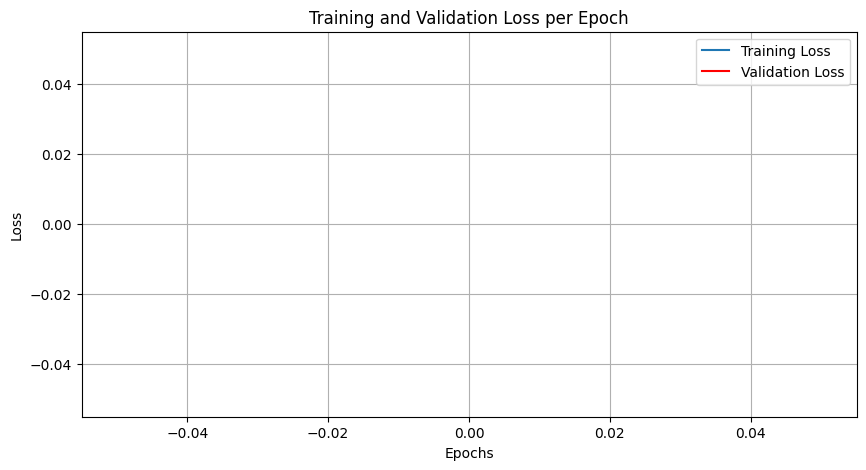

In [42]:
import matplotlib.pyplot as plt

# Logs you provided
log_history = [
    # Your log data goes here
]

# Extracting losses and epochs
epochs = []
train_loss = []
val_loss = []

for log in log_history:
    if 'loss' in log and 'epoch' in log:
        epochs.append(log['epoch'])
        train_loss.append(log['loss'])
    if 'eval_loss' in log and 'epoch' in log:
        val_loss.append(log['eval_loss'])

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(epochs[:len(train_loss)], train_loss, label='Training Loss')
plt.plot(epochs[len(train_loss):], val_loss, label='Validation Loss', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)


In [74]:
from transformers import pipeline
text = "f(x,y)"

classifier = pipeline("ner",model="taissirboukrouba/test-model")
classifier(text)

[{'entity': 'B-VAR',
  'score': 0.79370004,
  'index': 4,
  'word': ',',
  'start': 3,
  'end': 4}]

In [65]:
classifier.steps

AttributeError: 'TokenClassificationPipeline' object has no attribute 'steps'